# Numerical integration of advection-diffusion equations

The goal of the project is to learn general integration methods suited for parabolic partial differential equations frequently encountered in physics.

The prototypical example of such equations is the unidimensional advection-diffusion equation:
$$\frac{\partial u}{\partial t}+ V\frac{\partial u}{\partial x}=D \frac{\partial ^2 u}{\partial x^2} +f(u),  \qquad(Eq. 1)
$$
in a one-dimensional space domain of length $L$,  $x\in[0, L]$, with boundary conditions at $x=0$ and $x=L$, and initial condition at $t=0$.
Here we wish to follow the evolution in time $t$ for the variable $u(x,t)$, $x$ is the space variable, $V$ is an advection velocity, $D$ is the diffusion coefficient of $u$, $f$ is a source term (e.g. losses, nonlinear reaction, etc). The initial condition denotes the knowledge of $u(x,t=0)=u_0(x)$ for $x \in [0,\, L]$.  The boundary conditions can be of various type depending on the nature of the physical problem.

Periodic boundary conditions: $u(x=0,t)=u(x=L,t)$.

Neumann: $ \left.\dfrac{\partial u}{\partial x}\right|_{x=0} = \alpha ; \quad \left.\dfrac{\partial u}{\partial x}\right|_{x=L}=\beta.$

Dirichlet: $u(x=0,t)=\alpha; \quad u(x=L,t)=\beta.$

Examples in physics: heat equation ($u$ denotes temperature); transport of a tracer in a liquid ($u$ denotes the concentration); laser pulse propagation in an optical fiber ($u$ denotes the electric field amplitude $D\in i \mathbb{R}$ ); time dependent Schrödinger equation ($u$ denotes the wave function; $D \to i\hbar/2m, \ldots$); Ginzburg-Landau equation ($u$ denotes the amplitude of a pattern forming system).


# Part I: Spectral method (Fourier basis)

We will start by one of the easiest technique to integrate partial differential equations in one spatial dimension, belonging to the class of spectral methods, owing to the fact it is based on a decomposition of the solution into Fourier modes:

$$\hat u(k,t) = \int_{-\infty}^{+\infty} u(x,t) \exp ( -i k x) dx \qquad (Eq. FT)$$

Naturally this decomposition is well suited to problems with periodic boundary conditions. However, it is possible to find approximate numerical solutions for problems with, e.g., Dirichlet boundary conditions using this method as well, provided special attention is paid to possible artifacts on the boundaries. We assume first periodic boundary conditions due to the use of the Fourier basis. However, we will consider an advection-diffusion problem in an infinite spatial domain and will chose a large enough numerical box size for the calculated solution with the inherent periodic boundary conditions to be a good approximation for the true solution.

By applying a Fourier transform to (Eq. 1), we obtain:
$$\frac{\partial \hat u}{\partial t}+ V(ik \hat u)=D (-k^2) \hat u +\hat f(u),  \qquad(Eq. 2)$$

We will limit this example to the case without source term $f(u)=0$, leading to the linear differential equation:
$$\frac{\partial \hat u}{\partial t}= -(D k^2 + ik V) \hat u ,  \qquad\qquad\qquad(Eq. 3)$$
and to its solution:
$$ \hat u(k,t)= \hat u_0(k) \exp(-(D k^2 + ik V)t) \qquad (Eq. P)$$
An inverse Fourier transform allows us to find the solution 
$$u(x,t) = \frac{1}{2\pi}\int_{-\infty}^{+\infty} \hat{u}(k,t) \exp ( i k x) dk \qquad (Eq. FT^{-1}) $$

## Numerical implementation:

Thanks to the availability of generic fast Fourier transforms (FFT, FFT$^{-1}$) algorithms, allowing us to calculate the discretized versions of ($Eq. FT$) and ($Eq. FT^{-1}$), the above development suggests how to compute the solution $u(x,t)$.

Let us first discretize both time and space as follows:
$$t_n=n \Delta t, \quad n=0,…,N_t−1,$$
$$x_j=j \Delta x, \quad j=0,…,N_x−1,$$

Our ultimate goal is to construct a numerical method that allows us to approximate the unknonwn analytic solution $u(x,t)$ reasonably well in these discrete grid points.

That is, we want to construct a method that computes values $U(j\Delta x,n \Delta t)$
(note: capital $U$) so that
$$U(j\Delta x,n\Delta t)≈u(j\Delta x,n\Delta t)$$
As a shorthand we will write $U^n_j=U(j\Delta x,n\Delta t)$ and $(j,n)$ to refer to grid point $(j\Delta x,n\Delta t)$.

The variable $\hat U(j\Delta k,n\Delta t)$ denotes the discretized version for the Fourier transformed function $\hat u(k,t)$. 
A suitable discretization of the spectral space for wavenumbers $k$ reads:
$$k_j=j \Delta k, \quad j=-N_x/2,…,N_x/2-1, \qquad \Delta k= \frac{2\pi}{N_x\Delta x}$$

The critical Nyquist (wavenumber) frequency ($k_c=2\pi f_c$) $f_c=\frac{1}{2 \Delta x}$

__Note: Numerical implementations of FFT commonly rearrange the positive and negative frequencies. For A = fft(a), the zero frequency component is ```A[0]```, the positive frequency components are ```A[1:N/2]```, and the negative frequencies are ```[N/2+1:]```. Numpy's ```fftfreq``` function returns frequencies $k$ for a given grid spacing $\Delta x$ and takes this reordering into account.__

__Note: Numerical FFT's have the best performance when the length of the array $N$ is a power of 2, i.e. $N = 2^n$__


## Algorithm steps:
The following three-step algorithm allows us to calculate the solution $u(x,t)$ from $u(x,t=0)$
at all times:

1. Calculate $\hat U_j^0$ by applying a FFT procedure to $U_j^0$.

2. Multiply by $\hat U_j^n =\hat U_j^0\exp(-(D k_j^2 + i V k_j)\, n \Delta t)$

3. Calculate $U_j^n$ by applying an IFFT procedure to $\hat U_j^n$.


Note that in the second step, an evolution  from $\hat u (k,t=0)$ to $\hat u (k,t)$ is directly performed in a single step. In practice (to solve more complicated PDEs with a non-zero source term $f(u)$), it is useful to perform a series of steps of size $\Delta t$, as will be shown below.

## Part I.1: Create the initial condition

We are going to use a Gaussian function for the initial condition. Sometimes it is convenient to use a class in place of a function, especially when the function has many constant parameters. The strategy is to separate the constant parameters from the parameters that change.

We do this by passing all of the constant parameters during initialization (using the ```__init__``` method) and saving them in the class. Then, all non-constant values will be passed into the special method ```__call__```, where we will evaluate the Gaussian function. In Python, the method ```__call__``` allows classes to be used like a function. The syntax ```func(x)``` invokes the ```__call__``` method of object ```func```, explicitly ```func.__call__(x)```.

Define a class for the Gaussian function:
```python
class Gaussian:
    """Gaussian function"""
    def __init__(self, width, amplitude, x0):
        """Create Gaussian with the given width and amplitude, centered at x = x0"""
        self.width = width
        # ...
        
    def __call__(self, x):
        return # ...
```

Create a Gaussian object with parameters for the width, amplitude, and shift
```python
gauss = Gaussian(1, 1, 0.5)
```

Since we defined the ```__call__``` method, the Gaussian object can be evaluated like a function
```python
gauss(0.5) # 1.0
gauss(numpy.array([0, 1, 2, 3])) # array([0.77880078, 0.77880078, 0.10539922, 0.00193045])
```

Plot your Gaussian function to verify that you've implemented it correctly.

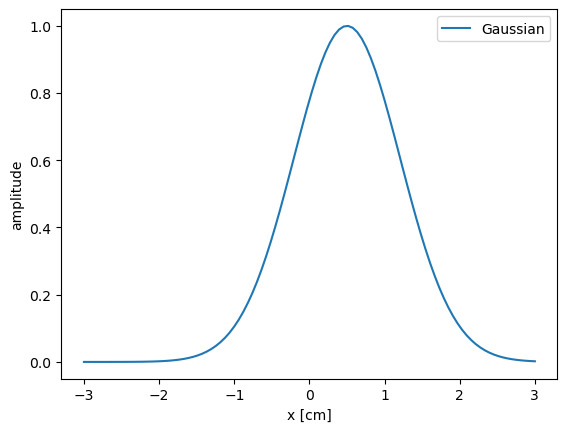

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


class Gaussian:
    """Gaussian function"""
    def __init__(self, width, amplitude, x0):
        """Create Gaussian with the given width and amplitude, centered at x = x0"""
        self.width = width
        self.amp = amplitude
        self.x0 = x0
        
    def __call__(self, x):
        """Evaluate the function for the values of x"""
        return self.amp * np.exp(-(x-self.x0)**2 / self.width**2)


# create a Gaussian object
gauss = Gaussian(1, 1, 0.5)

# plot the results
x = np.linspace(-3, 3, 100)

fig, ax = plt.subplots()
ax.plot(x, gauss(x), label='Gaussian')
ax.set_xlabel('x [cm]')
ax.set_ylabel('amplitude')
ax.legend()

## Part I.2: Define a class to advance the solution from $t$ to $t+\Delta t$

This class should create the spatial $x$ and spectral $k$ grids (consider using the function numpy.fft.fftfreq), set the parameters $D$ and $V$, and provide a way to set the initial condition. It should also define the method  ```step(self, dt)``` for evolving $u(x,t) \to u(x,t+\Delta t)$. This method contains the core of the algorithm, i.e., the three substeps:

1) Transform $u(x,t) \to \hat u(k,t)$ using FFT

2) Advance one time step $\Delta t$ using Eq. (P)

3) Transform $\hat u(k,t) \to u(x,t)$  using FFT$^{-1}$

```python
class Spectral:
    def __init__(self, L, number_of_points, D, ...):
        pass
        
    def initialize(self, function):
        pass
        
    def step(self, dt):
        pass
```

In [2]:
class Spectral:
    """Spectral stepping method for solving PDEs"""
    def __init__(self, L, Nx, D, V):
        """Initialize the spatial and spectral grids"""
        self.L = L
        self.Nx = Nx
        self.D = D
        self.V = V
        self.x, self.dx = np.linspace(0, L, self.Nx, retstep=True)
        self.k = 2*np.pi*np.fft.fftfreq(self.Nx, d=self.dx)
        
        self.u = np.zeros(Nx)
        
    def initialize(self, func):
        """Set the initial condition"""
        self.u = func(self.x)
        
    def step(self, dt):
        """Make a step dt forward in time"""
        uk = np.fft.fft(self.u)
        uk *= np.exp(-(self.D*self.k**2 + 1j*self.V*self.k) * dt)
        self.u = np.fft.ifft(uk).real

## Part I.3: Time evolution
Write a function ```advance(spectral, T, N)``` that evolves $u(x,0) \to u(x,T)$ using $N$ steps

In [3]:
def advance(spectral, T, Nt):
    dt = T / Nt
    for _ in range(Nt):
        spectral.step(dt)

## Part I.4: Check the results
1. Plot the solution at $T$, compare with the solution at $t=0$ and with the expected analytical solution at $t=T$; chose a solvable problem, e.g. pure diffusion of the concentration of a tracer with $V=0$:
$$u(x,t)=\frac{U_0}{\sqrt {1 + \frac{4Dt}{\sigma^2}}}\exp \left (-\frac{(x-x_0)^2}{\sigma^2+4Dt}\right )$$ 

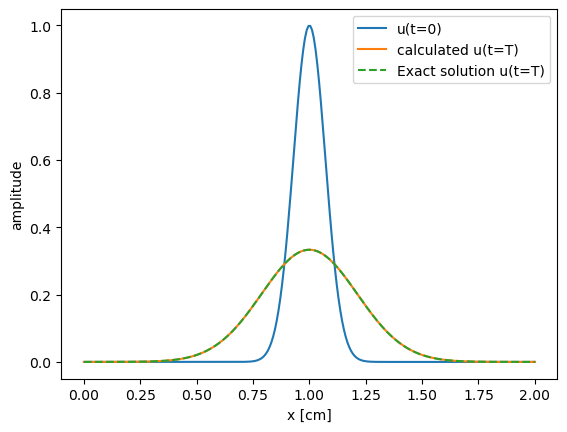

In [4]:
# Diffusion solution
class DiffusiveGaussian:
    def __init__(self, sigma, x0, D, U0=1):
        self.sigma = sigma
        self.x0 = x0
        self.D = D
        self.U0 = U0
        
    def __call__(self, x, t=0):
        A = self.U0 / np.sqrt(1 + 4*self.D*t / self.sigma**2)
        return A * np.exp(-(x - self.x0)**2 / (self.sigma**2 + 4*self.D*t))
        

        
L, Nx, D, V = 2, 256, 0.1, 0
sigma, x0 = 0.1, 1
T, Nt = 0.2, 10

sol = DiffusiveGaussian(sigma, x0, D)
spectral = Spectral(L, Nx, D, V)
spectral.initialize(sol)
advance(spectral, T, Nt)

x = spectral.x

fig, ax = plt.subplots()
ax.plot(x, sol(x, 0), label='u(t=0)')
ax.plot(x, spectral.u, label='calculated u(t=T)')
ax.plot(x, sol(x, T), label='Exact solution u(t=T)', linestyle='dashed')
ax.set_xlabel('x [cm]')
ax.set_ylabel('amplitude')
ax.legend()

2. Check the solution at $t=T$ for the purely advective part ($D=0$).
Hints: any function of $(x-Vt)$ is a solution to $u_t+V u_x=0$. Check the validity of the propagated solution for a Gaussian pulse initial condition.

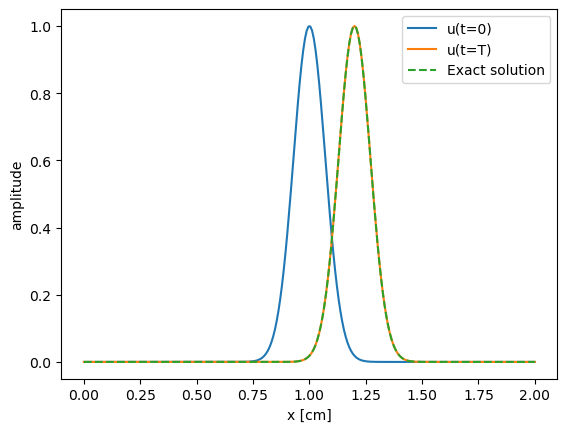

In [5]:
# Advective solution
# We will reuse our Gaussian class and shift the value of x -> x - V*T
        
L, Nx, D, V = 2, 256, 0, 1
sigma, x0 = 0.1, 1
T, Nt = 0.2, 10

sol = Gaussian(sigma, 1, x0)
spectral = Spectral(L, Nx, D, V)
spectral.initialize(sol)
advance(spectral, T, Nt)

x = spectral.x

fig, ax = plt.subplots()
ax.plot(x, sol(x), label='u(t=0)')
ax.plot(x, spectral.u, label='u(t=T)')
ax.plot(x, sol(x-V*T), label='Exact solution', linestyle='dashed')
ax.set_xlabel('x [cm]')
ax.set_ylabel('amplitude')
ax.legend()

# Part 2: Finite differences, the Crank-Nicolson method

The Crank-Nicolson method is a well-known finite difference method for the numerical integration of advection-diffusion equations and parabolic partial differential equations in general. It was initially proposed for solving the heat equation.

We will resort to the Crank-Nicolson (CN) scheme to integrate numerically Eq. 1 in one space dimension with Neumann boundary conditions.
$$\frac{\partial u}{\partial t}+ V\frac{\partial u}{\partial x}=D \frac{\partial ^2 u}{\partial x^2} +f(u),  \qquad(Eq. 1)$$
$$ \left.\frac{\partial u}{\partial x}\right\vert_{x=0,L}=0,$$

Neumann boundary conditions specifies that the solution $u$ (e.g. a concentration)
has zero space gradient at the boundaries, effectively prohibiting entrance or exit of material at the boundaries (no-flux boundary conditions).

# Finite Difference Methods

Here we describe a few basic aspects of finite difference methods.

The above advection-diffusion equation describes the time evolution of variable $u(x,t)$ in one space dimension.

To approximate $u(x,t)$ numerically we discretize the two-dimensional coordinate system in the same way as before resulting in a two-dimensional regular grid. This is the simplest case; the method can be applied to irregular grids with minor changes.

Let us discretize both time and space with regular grids:
$$t_n=n \Delta t,\quad n=0,…,N−1,$$
$$x_j=j \Delta x,\quad j=0,…,J−1,$$

where $N$ and $J$ are the number of discrete time and space points in our grid, respectively. $Δt$ and $Δx$ are the time step and space step respectively and defined as follows:
$$Δt=T/N,$$
$$Δx=L/J,$$

where $T$ is the point in time up to which we will integrate $u$ numerically.

As in part 1, our ultimate goal is to construct a numerical method that allows us to approximate the unknown analytic solution $u(x,t)$ reasonably well in these discrete grid points, using the same shorthand notation
$$U^n_j=U(jΔx,nΔt)≈u(jΔx,nΔt)$$

# The Crank-Nicolson Stencil

Based on the two-dimensional grid we construct approximate operators of our advection-diffusion equation.

For instance, to approximate the time derivative on the left-hand side in grid point $(j,n)$
we use the values of $U$ in two specific grid points:
$$\left.\frac{\partial u}{\partial t}\right \vert_{x=jΔx,t=nΔt}≈\frac{U^{n+1}_j−U^n_j}{Δt}.$$

We can think of this scheme as a stencil that we superimpose on our $(x,t)$-grid and this particular stencil is commonly referred to as forward difference.

The spatial part of the Crank-Nicolson stencil for the advection-diffusion equation ($u_t=D u_{xx} -V u_x + f(u)$) approximates the Laplace and advection operators of our equation and takes the following form
$$D\left.\frac{\partial^2 u}{\partial x^2}\right \vert_{x=jΔx,t=nΔt}≈\frac{D}{2Δx^2}\left(U^n_{j+1}−2U^n_j+U^n_{j−1}+U^{n+1}_{j+1}−2U^{n+1}_j+U^{n+1}_{j−1} \right).$$
$$V\left.\frac{\partial u}{\partial x}\right \vert_{x=jΔx,t=nΔt}≈\frac{V}{4Δx}\left(U^n_{j+1}−U^n_{j−1}+U^{n+1}_{j+1}−U^{n+1}_{j−1} \right).$$

To approximate $f(u(jΔx,nΔt))$ we can simply write simply $f(U^n_j)$, or $(3/2)f(U^n_j)- (1/2)f(U^{n-1}_j)$ if the second order accuracy of the CN scheme is to be preserved.

These approximations define the stencil for our numerical method as pictured on Wikipedia.

![](CN_stencil.svg)

Applying this stencil to grid point $(j,n)$ gives us the following approximation of our reaction-diffusion equation:

$$\frac{U^{n+1}_j−U^n_j}{Δt}=\frac{D}{2Δx^2}(U^n_{j+1}−2U^n_j+U^n_{j−1}+U^{n+1}_{j+1}−2U^{n+1}_j+U^{n+1}_{j−1})$$

$$\qquad        - \frac{V}{4Δx}(U^n_{j+1}−U^n_{j−1}+U^{n+1}_{j+1}−U^{n+1}_{j−1})+f(U^n_j).$$
        

# Reordering Stencil into Linear System

Let us define $\sigma \equiv \frac{DΔt}{2Δx^2}$, $\nu\equiv \frac{VΔt}{4Δx}$ and reorder the above approximation of our reaction-diffusion equation:
$$−(\sigma+\nu)U^{n+1}_{j−1}+(1+2\sigma)U^{n+1}_j−(\sigma-\nu )U^{n+1}_{j+1}=(\sigma+\nu)U^n_{j−1}+(1−2\sigma)U^n_j+(\sigma-\nu)U^n_{j+1}+Δt f(U^n_j).$$

This equation makes sense for space indices $j=1,…,J−2$ but it does not make sense for indices $j=0$ and $j=J−1$

(on the boundaries):
$$j=0: −(σ+\nu)U^{n+1}_{−1}+(1+2σ)U^{n+1}_{0}−(σ-\nu)U^{n+1}_{1}=(σ+\nu)U^n_{−1}+(1−2σ)U^n_0+(σ-\nu)U^n_1+Δt \, f(U^n_0),$$
$$j=J−1: −(σ+\nu)U^{n+1}_{J−2}+(1+2σ)U^{n+1}_{J−1}−(σ-\nu)U^{n+1}_J=(σ+\nu)U^n_{J−2}+(1−2σ)U^n_{J−1}+(σ-\nu)U^n_J+Δt\,f(U^n_{J−1}).$$

The problem here is that the values $U^{n−1}_{-1}$ and $U^n_J$ lie outside our grid.

However, we can work out what these values should equal by considering our Neumann boundary condition. Let us discretize our boundary condition at $j=0$ with the backward difference and at $j=J−1$ with the forward difference:
$$\frac{U^n_1−U^n_{-1}}{2Δx}=0,$$
$$\frac{U^n_J−U^n_{J−2}}{2Δx}=0.$$

These two equations make it clear that we need to amend our above numerical approximation for $j=0$ with the identities $U^n_{-1}=U^n_1$ and $U^{n+1}_{-1}=U^{n+1}_1$, and for $j=J−1$ with the identities $U^n_{J−2}=U^n_J$ and $U^{n+1}_{J−2}=U^{n+1}_J$.

Let us reinterpret our numerical approximation of the line concentration of $u$
in a fixed point in time as a vector $\mathbf{U}^n$:
$$\mathbf{U}^n=\left [  
\begin{array}{c}
U_0^n \\
\vdots \\
U_{J-1}^n
\end{array}\right ].$$

Using this notation we can now write our above approximation for a fixed point in time, $t=n \Delta t$, compactly as a linear system:
$$\left [  
\begin{array}{ccccccc}
1+2\sigma & - 2\sigma & 0 & 0 & \ldots & 0 \\
-(\sigma+\nu) & 1+ 2 \sigma & - (\sigma-\nu) & 0 & \ldots & 0 \\
 0 & -(\sigma+\nu) & 1+ 2 \sigma & - (\sigma-\nu) & \ldots & 0 \\
 0 & 0 & \ddots & \ddots  & \ddots & 0 \\
 0 & 0 & 0 &-(\sigma+\nu) & 1+ 2 \sigma & - (\sigma-\nu) \\
 0 & 0 & 0 & 0 &-2\sigma & 1+ 2 \sigma
\end{array}\right ]
\left [  
\begin{array}{c}
U_0^{n+1} \\
U_1^{n+1} \\
U_2^{n+1} \\
\vdots \\
U_{J-2}^{n+1}\\
U_{J-1}^{n+1}\\
\end{array}\right ]=
$$
$$
\left [  
\begin{array}{ccccccc}
1-2\sigma & + 2\sigma & 0 & 0 & \ldots & 0 \\
\sigma+\nu & 1 -2 \sigma & + \sigma-\nu & 0 & \ldots & 0 \\
 0 & \sigma+\nu & 1- 2 \sigma & + \sigma-\nu & \ldots & 0 \\
 0 & 0 & \ddots & \ddots  & \ddots & 0 \\
 0 & 0 & 0 &+\sigma+\nu & 1- 2 \sigma & + \sigma-\nu \\
 0 & 0 & 0 & 0 &+2\sigma & 1- 2 \sigma
\end{array}\right ]
\left [  
\begin{array}{c}
U_0^{n} \\
U_1^{n} \\
U_2^{n} \\
\vdots \\
U_{J-2}^{n}\\
U_{J-1}^{n}\\
\end{array}\right ]+
\Delta t \left [ \begin{array}{c}
f(U_0^{n}) \\
f(U_1^{n}) \\
f(U_2^{n}) \\
\vdots \\
f(U_{J-2}^{n})\\
f(U_{J-1}^{n})\\
\end{array}\right ]
$$


Note that since our numerical integration starts with a well-defined initial condition at $n=0$, $U^0$, the vector $\mathbf{U}^{n+1}$
on the left-hand side is the only unknown in this system of linear equations.

Thus, to integrate numerically our advection-diffusion system from time point $n$ to $n+1$ we need to solve numerically for vector $\mathbf{U}^{n+1}$.

Let us call the matrix on the left-hand side $A$, the one on the right-hand side $B$, and the vector on the right-hand side $f^n$. Using this notation we can write the above system as
$$AU^{n+1}=BU^n+F^n,$$

where $F^n\equiv \Delta t f (U^n)$. In this linear equation, matrices $A$ and $B$ are defined by our problem: we need to specify these matrices once for our problem and incorporate our boundary conditions in them. Vector $F^n$ is a function of $U^n$ and so needs to be reevaluated in every time point $n$. We also need to carry out one matrix-vector multiplication every time point, $BU^n$, and one vector-vector addition, $BU^n+F^n$.

The most expensive numerical operation is inversion of matrix $A$
to solve for $U^{n+1}$, however we may get away with doing this only once and store the inverse of $A$ as $A^{−1}$:

$$U^{n+1}=A^{−1}(BU^n+F^n). \quad (Eq. CN1).$$

Without the vector $F^n$ on the right hand side, the Crank-Nicolson scheme is a second order scheme that is unconditionally stable. In the presence of a source term $F^n$ on the right hand side, the Crank-Nicolson scheme defined by (Eq. CN1) is only a first order scheme. In order to preserve the second order accuracy, the source term must be modified as:

$$U^{n+1}=A^{−1}(BU^n+\frac{3}{2}F^n-\frac{1}{2}F^{n-1}). \quad (Eq. CN2)$$


## Part II.1: Create Crank-Nicolson class to solve Eq. CN2
Your class implementation should provide the following functionality:
1. Initialize the spatial grid and temporal grids
2. Set the parameters $D$ and $V$, as well as the function $f$
3. Create the matrices $A$ and $B$. Hint: numpy's diagflat is useful for setting the diagonal elements of an array
4. The ability to modify the values in $A$ and $B$ for implementing Dirichlet and Neumann boundary conditions
5. Solve Eq. CN2 using scipy.linalg.solve
6. Optional: Since the system is tri-diagonal, you could use ```scipy.linalg.solve_banded``` in place of the standard ```solve```. This will make your code much faster. Make sure you read the documentation page, since ```solve_banded``` expects the matrices to be in a special format.

Reminder: To perform matrix-vector multiplication using numpy arrays, use the syntax of ```A.dot(B)```, since ```A*B``` is element-wise multiplication.

In [9]:
import numpy as np
import scipy.sparse
import scipy.linalg as la

class CrankNicolson:
    """A class that solves du/dt + V du/dx = D du2/dx2 + f(u)"""
    
    def set_grid(self, x_min, x_max, n_x, t_min, t_max, n_t):

        self.x_min, self.x_max, self.n_x = x_min, x_max, n_x
        self.t_min, self.t_max, self.n_t = t_min, t_max, n_t
        self.x_pts, self.delta_x = np.linspace(x_min, x_max, n_x, retstep=True, endpoint=False)
        self.t_pts, self.delta_t = np.linspace(t_min, t_max, n_t, retstep=True, endpoint=False)
        
    def set_parameters(self, D, V, f):
        
        self.V, self.D, self.f = V, D, f

    def solve(self, u_init, sparse=True, boundary_conditions=('neumann','neumann')):
            
        sig = self.D * self.delta_t / 2. / self.delta_x**2
        nu = self.V * self.delta_t / 4. / self.delta_x
        
        # Figure the data type
        data_type = type(sig*nu*u_init[0])
        
        self.u_matrix = np.zeros([self.n_t, self.n_x], dtype=data_type)

        # Using sparse matrices and specialized tridiagonal solver speeds up the calculations
        if sparse:
            
            A = self._fillA_sp(sig, nu, self.n_x, data_type)
            B = self._fillB_sp(sig, nu, self.n_x, data_type)
            # Set boundary conditions
            for b in [0,1]:
                if boundary_conditions[b] == 'dirichlet':
                    # u(x,t) = 0
                    A[1,-b] = 1.0
                    A[2*b,1-3*b] = 0.0
                    B[-b,-b] = 0.0
                    B[-b,1-3*b] = 0.0
                elif boundary_conditions[b] == 'neumann':
                    # u'(x,t) = 0
                    A[2*b,1-3*b] = -2*sig
                    B[-b,1-3*b] = 2*sig
                    
            # Propagate
            u = u_init
            for n in range(self.n_t):
                self.u_matrix[n,:] = u
                fu = f(u)
                if n==0: fu_old = fu
                u = la.solve_banded((1,1),A, B.dot(u) + self.delta_t * (1.5 * fu - 0.5 * fu_old),\
                                    check_finite=False)
                fu_old = fu

        else:
            
            A = self._make_tridiag(sig, nu, self.n_x, data_type)
            B = self._make_tridiag(-sig, -nu, self.n_x, data_type)

            # Set boundary conditions
            for b in [0,1]:
                if boundary_conditions[b] == 'dirichlet':
                    # u(x,t) = 0
                    A[-b,-b] = 1.0
                    A[-b,1-3*b] = 0.0
                    B[-b,-b] = 0.0
                    B[-b,1-3*b] = 0.0
                elif boundary_conditions[b] == 'neumann':
                    # u'(x,t) = 0
                    A[-b,1-3*b] = -2*sig
                    B[-b,1-3*b] = 2*sig

            # Propagate
            u = u_init
            for n in range(self.n_t):
                self.u_matrix[n,:] = u
                fu = f(u)
                if n==0: fu_old = fu
                u = la.solve(A, B.dot(u) + self.delta_t * (1.5 * fu - 0.5 * fu_old))
                fu_old = fu
            
    def get_final_u(self):
        
        return self.u_matrix[-1,:].copy()
        
    def _make_tridiag(self, sig, nu, n, data_type):
    
        M = np.diagflat(np.full(n, (1+2*sig), dtype=data_type)) + \
            np.diagflat(np.full(n-1, -(sig-nu), dtype=data_type), 1) + \
            np.diagflat(np.full(n-1, -(sig+nu), dtype=data_type), -1)

        return M
    
    def _fillA_sp(self, sig, nu, n, data_type):
        """Returns a tridiagonal matrix in compact form ab[1+i-j,j]=a[i,j]"""
        
        A = np.zeros([3,n], dtype=data_type) # A has three diagonals and size n
        A[0] = -(sig-nu) # superdiagonal
        A[1] = 1+2*sig # diagonal
        A[2] = -(sig+nu) # subdiagonal
        return A

    def _fillB_sp(self, sig, nu, n, data_type):
        """Returns a tridiagonal sparse matrix in csr-form"""
        
        _o = np.ones(n, dtype=data_type)
        supdiag = (sig-nu)*_o[:-1]
        diag = (1-2*sig)*_o
        subdiag = (sig+nu)*_o[:-1]
        return scipy.sparse.diags([supdiag, diag, subdiag], [1,0,-1], (n,n), format="csr")

## Part II.2 - Tests
### 2.a Initial condition and spatial/temporal grids
1. A Gaussian for the initial condition, $\sigma = 5$, $x_0 = 50$, $U_0 = 2$
2. For the spatial grid, use 600 points to sample the domain (0, 100)
3. For the temporal grid, use 1000 points to sample (0, 200)

In [7]:
# Helper function
def gaussian(x, x0, sigma, U_0):
    return U_0 * np.exp(-(x-x0)**2/(sigma**2))

# Those will not change
x_min, x_max, nx = 0, 100., 600
t_min, t_max, nt = 0, 200., 1000

# Construct the general Crank-Nicolson solver
crank = CrankNicolson()
crank.set_grid(x_min, x_max, nx, t_min, t_max, nt)

### 2.b Purely diffusive case
Use the parameters $D = 1$, $V = 0$, $f(u) = 0$ and plot the solution $u(x,t)$ using matplotlib's ```pcolormesh```.

time to advance 1000 steps with full (600 x 600) matrices : 298.430757 s
time to advance 1000 steps with sparse (600 x 600) matrices : 0.331470999999965 s


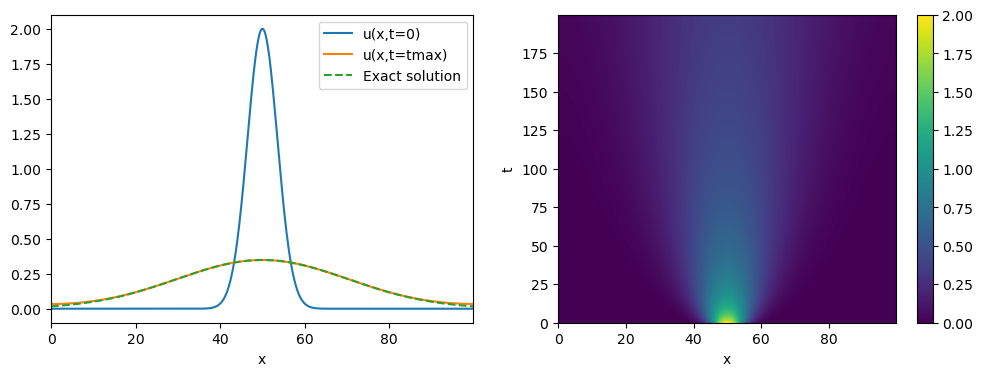

In [10]:
import matplotlib.pyplot as plt
from time import process_time

D,V = 1.0,0.0
f = lambda u: 0.0
crank.set_parameters(D, V, f)

s, x0, u0 = 5., 50., 2.
u = gaussian(crank.x_pts, x0, s, u0)
t1 = process_time()
crank.solve(u, sparse=False)
t2 = process_time()
print("time to advance %i steps with full (%i x %i) matrices :"%(nt,nx,nx), t2-t1, "s")

t1 = process_time()
crank.solve(u, sparse=True)
t2 = process_time()
print("time to advance %i steps with sparse (%i x %i) matrices :"%(nt,nx,nx), t2-t1, "s")


fig, (ax1, ax2) = plt.subplots(1, 2,sharex=True,figsize=(12,4))
ax1.plot(crank.x_pts, u, label='u(x,t=0)')
ax1.plot(crank.x_pts, crank.get_final_u(), label='u(x,t=tmax)')
sp = np.sqrt(s**2 + 4*D*t_max)
u0p = u0 * s / sp
ax1.plot(crank.x_pts, gaussian(crank.x_pts, x0, sp, u0p), label='Exact solution', linestyle='dashed')
ax1.legend()
ax1.set_xlabel('x')

mesh = ax2.pcolormesh(crank.x_pts, crank.t_pts, crank.u_matrix, shading='auto')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
plt.colorbar(mesh, ax=ax2)

### 2.c Purely advective case
Use the parameters $D = 0$, $V = 1$, $f(u) = 0$ and plot the solution $u(x,t)$ using matplotlib's ```pcolormesh```.

Text(0, 0.5, 't')

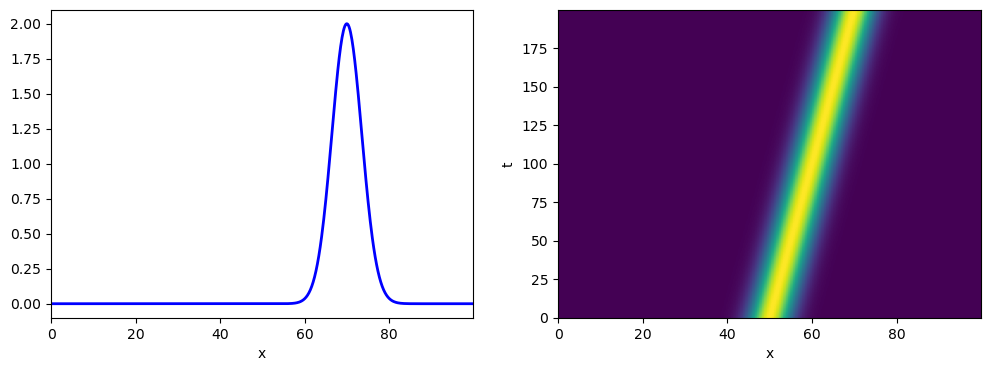

In [5]:
D, V = 0, 0.1
f = lambda u: 0.0
crank.set_parameters(D, V, f)

s, x0, u0 = 5., 50., 2.
u = gaussian(crank.x_pts, x0, s, u0)
crank.solve(u)

fig, (ax1, ax2) = plt.subplots(1, 2,sharex=True,figsize=(12,4))
ax1.plot(crank.x_pts, crank.get_final_u(), '-b', lw=2)
ax1.set_xlabel('x')
ax2.pcolormesh(crank.x_pts, crank.t_pts, crank.u_matrix, shading='auto')
ax2.set_xlabel('x')
ax2.set_ylabel('t')

## Part II.3 - Nonlinear evolution
1. Use the parameters $D = 1$, $V = 1.3$, $\mu = 1$, define $f(u)=\mu u - u^3$

2. modify the boundary condition at the origin: $u(x=0,t)=0$

3. modify the previously implemented Crank-Nicolson scheme to add nonlinearity $f(u)$. Implement Eq. (CN1) for simplicity, or Eq. (CN2) to preserve the second order accuracy of the Crank-Nicolson scheme.

4. Solve $u_t=-Vu_x + D u_{xx} + f(u)$  with $\mu=1$, and input condition $u(x,t=0)$ chosen as a random noise or as small amplitude localized pulse.

5. Vary advection velocity and comment on the calculated solution.

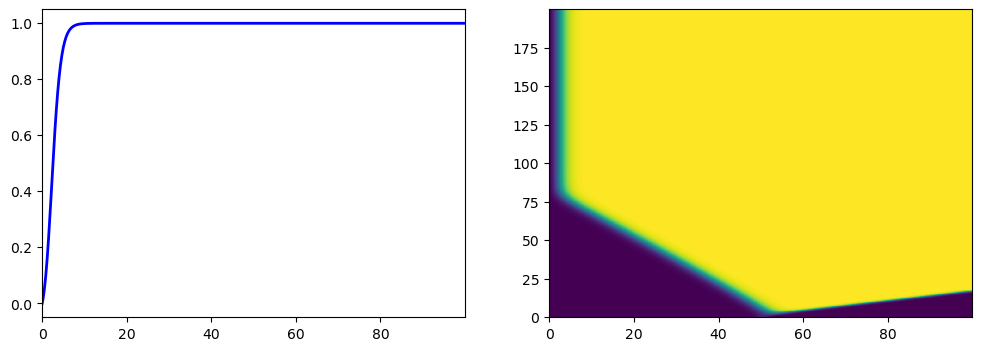

In [6]:
D, V, mu = 1.0, 1.3, 1.0
f = lambda u: mu*u - u**3
crank.set_parameters(D, V, f)

s, x0, u0 = 1., 50., 1.e-1
u = gaussian(crank.x_pts, x0, s, u0)
crank.solve(u, boundary_conditions=['dirichlet', 'neumann'])

fig, (ax1, ax2) = plt.subplots(1, 2,sharex=True,figsize=(12,4))
ax1.plot(crank.x_pts, crank.get_final_u(), '-b', lw=2)
ax2.pcolormesh(crank.x_pts, crank.t_pts, crank.u_matrix, shading='auto')

## Part II.4: Ginzburg-Landau Equation

$$\frac{\partial u}{\partial t}+ V\frac{\partial u}{\partial x}=(1+i\alpha) \frac{\partial ^2 u}{\partial x^2} +\mu u - (1+i \beta) \vert u \vert^2 u,  \qquad(Eq. 2)$$

This equation is called the Ginzburg-Landau equation and is well known in the context of pattern formation in unstable physical systems. It describes the growth and the saturation of instability waves over a basic state. A typical example is Rayleigh-Benárd convection (formation of convection rolls occurring in a plane horizontal layer of fluid heated from below), where in that case, $u$ represents the amplitude of the rolls.

Here we will go back to the boundary conditions $u_x(x=0)=0, \quad u_x(x=L)=0$ and to the case without advection $V=0$.

1. Modify the functions defining matrices $A$ and $B$ (if necessary) so as to fill them with complex values.

2. Modify the definition of the function $f(u)$ to match Eq. (2).

A variety of regimes exist depending on the parameter values and the initial condition. Examples can be found on the following link https://www.uni-muenster.de/imperia/md/content/physik_tp/lectures/ss2017/numerische_Methoden_fuer_komplexe_Systeme_II/gle.pdf

The following figure shows the "phase space" and the various regimes that are obtained.

![](phasediagram.jpg)


Check your changes with the following parameters: $\alpha = 0$, $\beta = -1.77$, $V=0$, $\mu = 1$.

Use an initial condition of the sum of two gaussians centered at $x_0 = 60$ and $x_1 = 30$, with amplitude $U_0 = 0.1 + 0.2j$ and $\sigma = 1$.

Plot the real and absolute value of $u(x,t)$.

Text(0.5, 1.0, 'Amplitude')

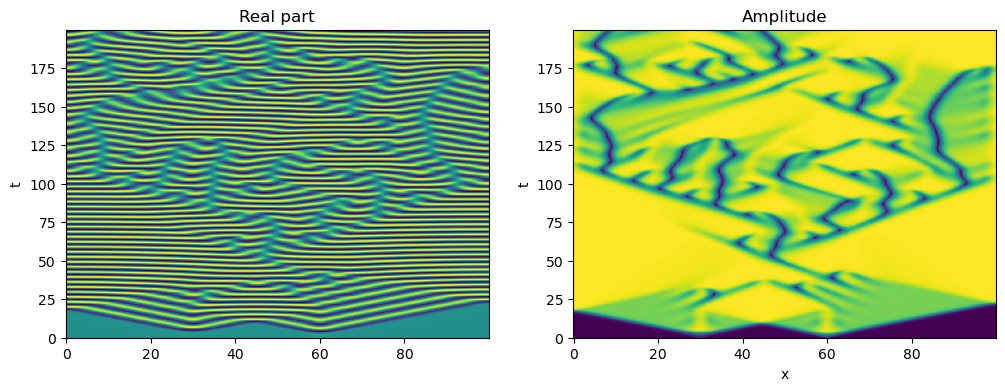

In [12]:
alpha, beta = 0., -1.77
u0 = 0.1 + 0.2j

D, V, mu = 1.0 + 1j*alpha, 0.0, 1.0
f = lambda u: mu*u - (1 + beta*1j) * np.abs(u)**2 * u
crank.set_parameters(D, V, f)

# Double gaussian u
x_01, x_02, s = 60.,30., 1.
u = u0 * (np.exp(-((crank.x_pts-x_01)/s)**2) + 0.5*np.exp(-((crank.x_pts-x_02)/s)**2))

crank.solve(u)

fig, (ax1, ax2) = plt.subplots(1, 2,sharex=True,figsize=(12,4))
ax1.pcolormesh(crank.x_pts, crank.t_pts, crank.u_matrix.real, shading='auto')
ax1.set_ylabel("t")
ax1.set_title("Real part")
ax2.pcolormesh(crank.x_pts, crank.t_pts, np.abs(crank.u_matrix), shading='auto')
ax2.set_xlabel("x")
ax2.set_ylabel("t")
ax2.set_title("Amplitude")  

Simulate the regime of defect mediated turbulence, $\alpha= 2$,$\beta=-2$ using an input condition of random noise (use complex values).


Text(0.5, 1.0, '|u|')

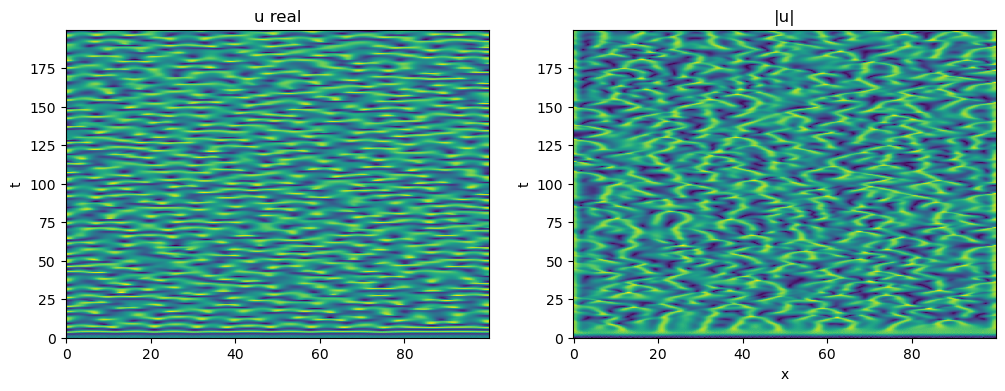

In [13]:
import numpy.random as rnd

alpha, beta = 2,-2
u0 = 0.1 + 0.2j

D, V, mu = 1.0 + 1j*alpha, 0.0, 1.0
f = lambda u: mu*u - (1 + beta*1j) * np.abs(u)**2 * u
crank.set_parameters(D, V, f)

# Random initial u
u = u0 * (rnd.rand(len(crank.x_pts)) + 1j*rnd.rand(len(crank.x_pts)))

crank.solve(u)

fig, (ax1, ax2) = plt.subplots(1, 2,sharex=True,figsize=(12,4))
ax1.pcolormesh(crank.x_pts, crank.t_pts, crank.u_matrix.real, shading='auto')
ax1.set_ylabel("t")
ax1.set_title("u real")
ax2.pcolormesh(crank.x_pts, crank.t_pts, np.abs(crank.u_matrix), shading='auto')
ax2.set_xlabel("x")
ax2.set_ylabel("t")
ax2.set_title("|u|")

Simulate the regime of phase turbulence $\alpha= 2$, $\beta=-1$ using random noise (complex) as the input condition.

Text(0.5, 1.0, '|u|')

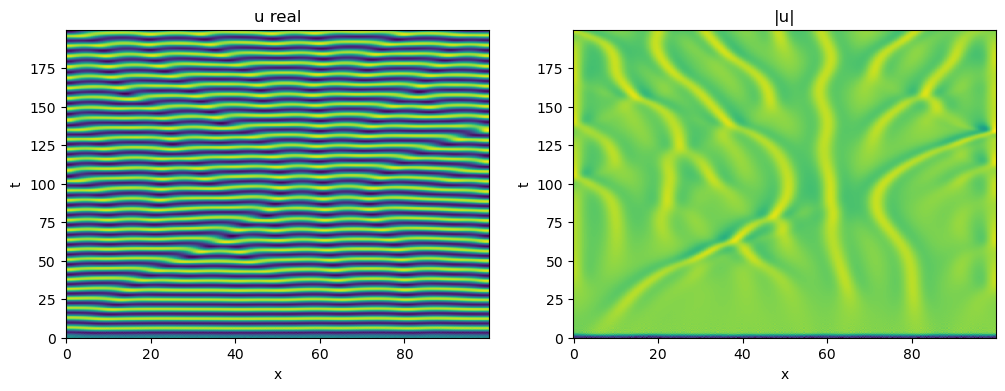

In [14]:
import numpy.random as rnd

alpha, beta = 2, -1
u0 = 0.1 + 0.2j

D, V, mu = 1.0 + 1j*alpha, 0.0, 1.0
f = lambda u: mu*u - (1 + beta*1j) * np.abs(u)**2 * u
crank.set_parameters(D, V, f)

# Random initial u
u = u0 * (rnd.rand(len(crank.x_pts)) + 1j*rnd.rand(len(crank.x_pts)))

crank.solve(u)

fig, (ax1, ax2) = plt.subplots(1, 2,sharex=True,figsize=(12,4))
ax1.pcolormesh(crank.x_pts, crank.t_pts, crank.u_matrix.real, shading='auto')
ax1.set_ylabel("t")
ax1.set_xlabel("x")
ax1.set_title("u real")
ax2.pcolormesh(crank.x_pts, crank.t_pts, np.abs(crank.u_matrix), shading='auto')
ax2.set_xlabel("x")
ax2.set_ylabel("t")
ax2.set_title("|u|")

Compare results with those plotted here:
https://www.uni-muenster.de/imperia/md/content/physik_tp/lectures/ss2017/numerische_Methoden_fuer_komplexe_Systeme_II/gle.pdf